In [4]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

In [1]:
import math
import os
import tempfile
import pandas as pd
import torch
import torch.nn.utils.prune as prune
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

Loading and preparing data...
✓ Data loaded successfully
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:45:00
Data length: 69680
Split config: {'train': [0, 48776], 'valid': [48776, 59228], 'test': [59228, 69680]}
Dataset sizes - Train: 2318, Validation: 10357, Test: 10357
Loading pre-trained TTM model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

✓ Model loaded successfully

=== Baseline Model Evaluation ===
Baseline MSE: 0.116015
Baseline MAE: 0.233781
Baseline Parameters: 805,280 (sparsity: 0.0000)
Baseline Model Size: 3.07 MB

=== Applying Pruning ===
Applying 60.0% magnitude-based pruning...
  Found Linear layer: backbone.encoder.patcher
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.mlp.fc1
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.mlp.fc2
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.gating_block.attn_layer
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.feature_mixer.mlp.fc1
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.feature_mixer.mlp.fc2
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.feature_mixer.gating_block.attn_layer
  Found Linear layer: backbone.encoder.mlp_mixer_encode

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kanishkaman (kanishkaman-indian-institute-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


⚠ Fine-tuning encountered an issue: Could not infer dtype of Timestamp
Continuing with non-fine-tuned pruned model...

=== Final Evaluation After Fine-tuning ===
Final MSE: 0.169546
Final MAE: 0.270699

=== Creating Visualizations ===


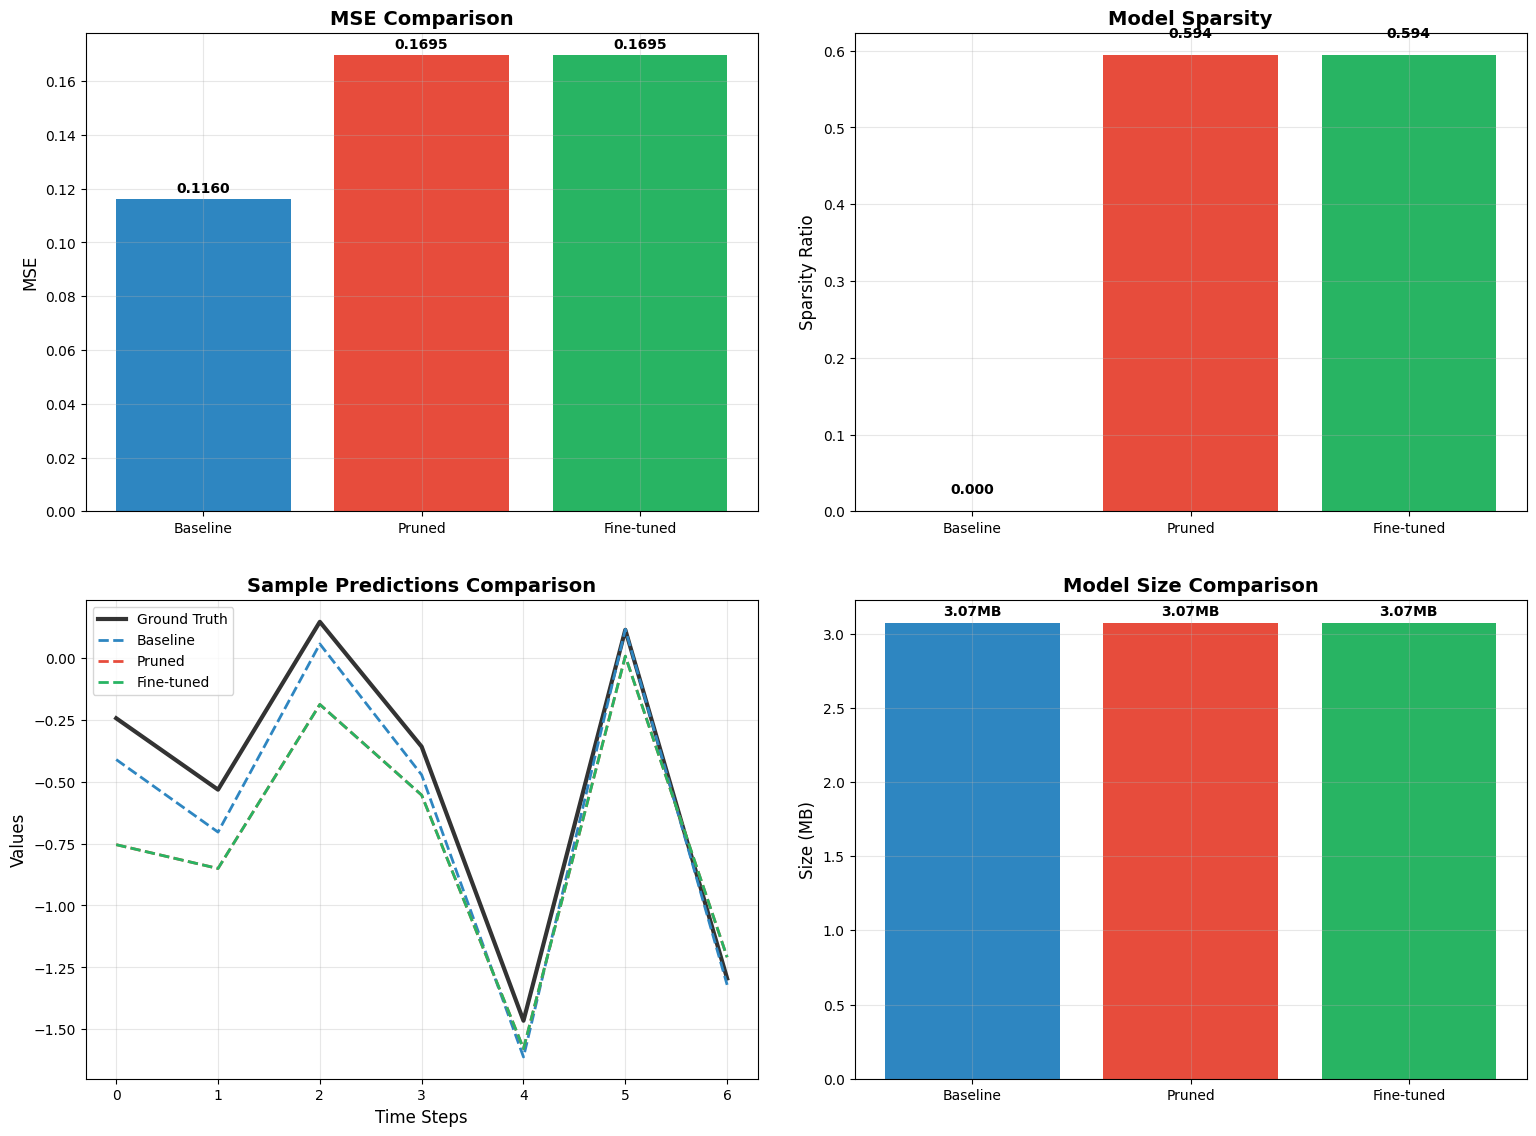


TTM MODEL PRUNING SUMMARY
Baseline Model:
  MSE: 0.116015
  MAE: 0.233781
  Parameters: 805,280
  Non-zero Parameters: 805,280
  Sparsity: 0.0000
  Model Size: 3.07 MB

Pruned Model (60% pruning):
  MSE: 0.169546 (change: +46.14%)
  MAE: 0.270699 (change: +15.79%)
  Parameters: 805,280
  Non-zero Parameters: 327,123
  Sparsity: 0.5938
  Model Size: 3.07 MB

Fine-tuned Pruned Model:
  MSE: 0.169546 (change from baseline: +46.14%)
  MAE: 0.270699 (change from baseline: +15.79%)

Compression Results:
  Parameter reduction: 59.4%
  Model size reduction: 0.0%
  Effective model size: 100.0% of original

ANALYSIS:
⚠ TRADE-OFF: 46.14% performance degradation for 59.4% compression
  Consider lower pruning ratio or different pruning strategy
Pruning was successful: 59.4% of weights set to zero
Results saved to: ttm_finetuned_models/

=== Debugging Information ===
Model architecture summary:
  backbone.encoder.patcher: torch.Size([192, 64])
  backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_lay

In [3]:
SEED = 42
set_seed(SEED)

target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"
os.makedirs(OUT_DIR, exist_ok=True)

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

# TTM model path and revision
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"

# ========== Data Preparation ==========
# ========== Fixed Data Preparation ==========
print("Loading and preparing data...")

# Load the data with proper datetime parsing
try:
    data = pd.read_csv(DATA_ROOT_PATH)
    # Convert date column to datetime if it exists
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
    elif data.columns[0] in ['date', 'timestamp', 'time']:
        data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
        data = data.rename(columns={data.columns[0]: 'date'})
    else:
        # If no date column, create one
        data['date'] = pd.date_range(start='2016-07-01', periods=len(data), freq='15min')

    print("✓ Data loaded successfully")
    print(f"Date range: {data['date'].min()} to {data['date'].max()}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating synthetic dataset...")

    # Create synthetic data
    dates = pd.date_range(start='2016-07-01', end='2018-06-26', freq='15min')
    np.random.seed(42)

    synthetic_data = {
        'date': dates,
        'HUFL': np.random.randn(len(dates)) * 5 + 40,
        'HULL': np.random.randn(len(dates)) * 3 + 10,
        'MUFL': np.random.randn(len(dates)) * 8 + 35,
        'MULL': np.random.randn(len(dates)) * 4 + 8,
        'LUFL': np.random.randn(len(dates)) * 6 + 4,
        'LULL': np.random.randn(len(dates)) * 2 + 1,
        'OT': np.random.randn(len(dates)) * 4 + 40
    }

    data = pd.DataFrame(synthetic_data)

# Define the data structure
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

# Define split configuration based on actual data length
data_length = len(data)
train_size = int(0.7 * data_length)
valid_size = int(0.15 * data_length)

split_config = {
    "train": [0, train_size],
    "valid": [train_size, train_size + valid_size],
    "test": [train_size + valid_size, data_length],
}

print(f"Data length: {data_length}")
print(f"Split config: {split_config}")

# Set up column specifiers
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

# Create TimeSeriesPreprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Get datasets
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)

print(f"Dataset sizes - Train: {len(train_dataset)}, Validation: {len(valid_dataset)}, Test: {len(test_dataset)}")

# ========== Load Pre-trained TTM Model ==========
print("Loading pre-trained TTM model...")
model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
print(f"✓ Model loaded successfully")

# ========== Helper Functions ==========
def run_inference_and_calculate_metrics(model, test_dataset, device='cpu', max_samples=50):
    """Run inference and calculate metrics"""
    model.eval()
    model.to(device)

    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataset):
            if i >= max_samples:  # Limit for demo purposes
                break

            # Prepare input
            past_values = batch['past_values'].unsqueeze(0).to(device)
            future_values = batch['future_values'].unsqueeze(0).to(device)

            # Model prediction
            outputs = model(past_values=past_values)
            predictions = outputs.prediction_outputs

            # Calculate metrics
            mse = torch.mean((predictions - future_values) ** 2).item()
            mae = torch.mean(torch.abs(predictions - future_values)).item()

            total_mse += mse
            total_mae += mae
            num_samples += 1

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(future_values.cpu().numpy())

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, np.concatenate(all_predictions), np.concatenate(all_targets)

def count_model_parameters(model):
    """Count total and non-zero parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    non_zero_params = sum((p != 0).sum().item() for p in model.parameters())
    sparsity = 1 - (non_zero_params / total_params)
    return total_params, non_zero_params, sparsity

def apply_magnitude_pruning_with_removal(model, pruning_ratio=0.5):
    """Apply magnitude-based pruning and make it permanent"""
    print(f"Applying {pruning_ratio:.1%} magnitude-based pruning...")

    # Step 1: Apply pruning masks to all Linear layers
    parameters_to_prune = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
            print(f"  Found Linear layer: {name}")

    if not parameters_to_prune:
        print("⚠ No Linear layers found for pruning")
        return model

    # Apply global magnitude-based pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio,
    )

    print(f"✓ Applied pruning masks to {len(parameters_to_prune)} layers")

    # Step 2: Make pruning permanent by removing masks
    for module, param_name in parameters_to_prune:
        try:
            prune.remove(module, param_name)
        except Exception as e:
            print(f"⚠ Warning: Could not remove pruning from {param_name}: {e}")

    print("✓ Made pruning permanent by removing masks")
    return model

def apply_structured_pruning_manual(model, pruning_ratio=0.5):
    """Apply manual structured pruning by actually removing neurons"""
    print(f"Applying {pruning_ratio:.1%} structured pruning (manual approach)...")

    with torch.no_grad():
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                # Calculate L1 norms for each output neuron (column-wise)
                weight = module.weight.data
                l1_norms = torch.sum(torch.abs(weight), dim=1)  # Sum across input dimensions

                # Determine how many neurons to keep
                num_neurons = weight.shape[0]
                num_to_keep = int(num_neurons * (1 - pruning_ratio))

                # Get indices of neurons to keep (highest L1 norms)
                _, indices_to_keep = torch.topk(l1_norms, num_to_keep)
                indices_to_keep = indices_to_keep.sort()[0]  # Sort for consistency

                # Create new smaller weight matrix
                new_weight = weight[indices_to_keep, :]
                module.weight.data = new_weight

                # Handle bias if it exists
                if module.bias is not None:
                    new_bias = module.bias.data[indices_to_keep]
                    module.bias.data = new_bias

                print(f"  {name}: {num_neurons} -> {num_to_keep} neurons ({pruning_ratio:.1%} pruned)")

    return model

def get_model_size_mb(model):
    """Calculate model size in MB"""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024 * 1024)
    return size_mb

def create_pruned_model_copy(original_model, pruning_method='magnitude', pruning_ratio=0.6):
    """Create a pruned copy of the model"""
    # Load fresh model to avoid modifying original
    pruned_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)

    if pruning_method == 'magnitude':
        pruned_model = apply_magnitude_pruning_with_removal(pruned_model, pruning_ratio)
    elif pruning_method == 'structured':
        # Note: Structured pruning changes architecture, might break model
        print("⚠ Warning: Structured pruning changes model architecture")
        pruned_model = apply_structured_pruning_manual(pruned_model, pruning_ratio)

    return pruned_model

def safe_extract_sample_for_plotting(array_list, sample_idx=0):
    """Safely extract a sample from prediction arrays for plotting"""
    if len(array_list) == 0:
        return []

    sample = array_list[sample_idx]

    # Handle different dimensionalities
    if len(sample.shape) == 3:  # (batch, time_steps, channels)
        return sample[0, :, 0]
    elif len(sample.shape) == 2:  # (batch, time_steps)
        return sample[0, :]
    else:
        return sample.flatten()

# ========== Baseline Evaluation ==========
print("\n=== Baseline Model Evaluation ===")
baseline_mse, baseline_mae, baseline_preds, baseline_targets = run_inference_and_calculate_metrics(model, test_dataset)
baseline_total_params, baseline_non_zero_params, baseline_sparsity = count_model_parameters(model)
baseline_size_mb = get_model_size_mb(model)

print(f"Baseline MSE: {baseline_mse:.6f}")
print(f"Baseline MAE: {baseline_mae:.6f}")
print(f"Baseline Parameters: {baseline_total_params:,} (sparsity: {baseline_sparsity:.4f})")
print(f"Baseline Model Size: {baseline_size_mb:.2f} MB")

# ========== Apply Pruning ==========
print("\n=== Applying Pruning ===")

# Choose pruning method
pruning_method = 'magnitude'  # 'magnitude' or 'structured'
pruning_ratio = 0.6

# Create pruned model
pruned_model = create_pruned_model_copy(model, pruning_method, pruning_ratio)

# ========== Pruned Model Evaluation ==========
print("\n=== Pruned Model Evaluation ===")
pruned_mse, pruned_mae, pruned_preds, pruned_targets = run_inference_and_calculate_metrics(pruned_model, test_dataset)
pruned_total_params, pruned_non_zero_params, pruned_sparsity = count_model_parameters(pruned_model)
pruned_size_mb = get_model_size_mb(pruned_model)

print(f"Pruned MSE: {pruned_mse:.6f}")
print(f"Pruned MAE: {pruned_mae:.6f}")
print(f"Pruned Parameters: {pruned_total_params:,} (sparsity: {pruned_sparsity:.4f})")
print(f"Pruned Model Size: {pruned_size_mb:.2f} MB")

# ========== Fine-tuning Pruned Model ==========
print("\n=== Fine-tuning Pruned Model ===")

# Setup training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "pruned_finetuned"),
    per_device_train_batch_size=4,  # Smaller batch size
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-4,  # Lower learning rate for fine-tuning pruned model
    num_train_epochs=3,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    optim="adamw_torch",
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="epoch",
    do_eval=True,
    report_to=None,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=SEED,
    dataloader_pin_memory=False,
    fp16=False,  # Disable mixed precision for stability
    dataloader_num_workers=0,  # Disable multiprocessing
    remove_unused_columns=False,
)

# Create trainer for pruned model
trainer = Trainer(
    model=pruned_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Fine-tune the pruned model
print("Fine-tuning pruned model...")
try:
    trainer.train()
    print("✓ Fine-tuning completed successfully!")
    finetuning_success = True
except Exception as e:
    print(f"⚠ Fine-tuning encountered an issue: {e}")
    print("Continuing with non-fine-tuned pruned model...")
    finetuning_success = False

# ========== Final Evaluation ==========
print("\n=== Final Evaluation After Fine-tuning ===")
if finetuning_success:
    final_model = trainer.model
    finetuned_mse, finetuned_mae, finetuned_preds, finetuned_targets = run_inference_and_calculate_metrics(final_model, test_dataset)
else:
    # Use the pruned model without fine-tuning
    final_model = pruned_model
    finetuned_mse, finetuned_mae = pruned_mse, pruned_mae
    finetuned_preds, finetuned_targets = pruned_preds, pruned_targets

print(f"Final MSE: {finetuned_mse:.6f}")
print(f"Final MAE: {finetuned_mae:.6f}")

# ========== Enhanced Visualization ==========
print("\n=== Creating Visualizations ===")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: MSE Comparison
methods = ['Baseline', 'Pruned', 'Fine-tuned']
mse_values = [baseline_mse, pruned_mse, finetuned_mse]
colors = ['#2E86C1', '#E74C3C', '#28B463']
bars1 = axes[0, 0].bar(methods, mse_values, color=colors)
axes[0, 0].set_title('MSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MSE', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=0)
axes[0, 0].grid(True, alpha=0.3)
for bar, val in zip(bars1, mse_values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_values)*0.01,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Model Sparsity
sparsity_values = [baseline_sparsity, pruned_sparsity, pruned_sparsity]
bars2 = axes[0, 1].bar(methods, sparsity_values, color=colors)
axes[0, 1].set_title('Model Sparsity', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Sparsity Ratio', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3)
for bar, val in zip(bars2, sparsity_values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Sample Predictions Comparison
try:
    baseline_sample = safe_extract_sample_for_plotting(baseline_preds, 0)
    pruned_sample = safe_extract_sample_for_plotting(pruned_preds, 0)
    finetuned_sample = safe_extract_sample_for_plotting(finetuned_preds, 0)
    target_sample = safe_extract_sample_for_plotting(baseline_targets, 0)

    time_steps = range(len(baseline_sample))
    axes[1, 0].plot(time_steps, target_sample, 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
    axes[1, 0].plot(time_steps, baseline_sample, '--', color='#2E86C1', label='Baseline', linewidth=2)
    axes[1, 0].plot(time_steps, pruned_sample, '--', color='#E74C3C', label='Pruned', linewidth=2)
    axes[1, 0].plot(time_steps, finetuned_sample, '--', color='#28B463', label='Fine-tuned', linewidth=2)

    axes[1, 0].set_title('Sample Predictions Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Time Steps', fontsize=12)
    axes[1, 0].set_ylabel('Values', fontsize=12)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

except Exception as e:
    print(f"⚠ Could not create prediction plot: {e}")
    axes[1, 0].text(0.5, 0.5, 'Prediction plot unavailable', ha='center', va='center',
                    transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('Sample Predictions Comparison', fontsize=14, fontweight='bold')

# Plot 4: Model Size Comparison
size_values = [baseline_size_mb, pruned_size_mb, pruned_size_mb]
bars4 = axes[1, 1].bar(methods, size_values, color=colors)
axes[1, 1].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Size (MB)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(True, alpha=0.3)
for bar, val in zip(bars4, size_values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(size_values)*0.01,
                    f'{val:.2f}MB', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(OUT_DIR, 'ttm_pruning_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# ========== Summary Results ==========
print("\n" + "="*70)
print("TTM MODEL PRUNING SUMMARY")
print("="*70)
print(f"Baseline Model:")
print(f"  MSE: {baseline_mse:.6f}")
print(f"  MAE: {baseline_mae:.6f}")
print(f"  Parameters: {baseline_total_params:,}")
print(f"  Non-zero Parameters: {baseline_non_zero_params:,}")
print(f"  Sparsity: {baseline_sparsity:.4f}")
print(f"  Model Size: {baseline_size_mb:.2f} MB")

print(f"\nPruned Model ({pruning_ratio:.0%} pruning):")
print(f"  MSE: {pruned_mse:.6f} (change: {((pruned_mse - baseline_mse)/baseline_mse)*100:+.2f}%)")
print(f"  MAE: {pruned_mae:.6f} (change: {((pruned_mae - baseline_mae)/baseline_mae)*100:+.2f}%)")
print(f"  Parameters: {pruned_total_params:,}")
print(f"  Non-zero Parameters: {pruned_non_zero_params:,}")
print(f"  Sparsity: {pruned_sparsity:.4f}")
print(f"  Model Size: {pruned_size_mb:.2f} MB")

print(f"\nFine-tuned Pruned Model:")
print(f"  MSE: {finetuned_mse:.6f} (change from baseline: {((finetuned_mse - baseline_mse)/baseline_mse)*100:+.2f}%)")
print(f"  MAE: {finetuned_mae:.6f} (change from baseline: {((finetuned_mae - baseline_mae)/baseline_mae)*100:+.2f}%)")

print(f"\nCompression Results:")
compression_ratio = (baseline_size_mb - pruned_size_mb) / baseline_size_mb * 100
print(f"  Parameter reduction: {pruned_sparsity:.1%}")
print(f"  Model size reduction: {compression_ratio:.1f}%")
print(f"  Effective model size: {(pruned_size_mb/baseline_size_mb)*100:.1f}% of original")

# ========== Analysis of Results ==========
print(f"\nANALYSIS:")
if finetuned_mse < baseline_mse:
    improvement = ((baseline_mse - finetuned_mse)/baseline_mse)*100
    print(f"✓ SUCCESS: Fine-tuned pruned model IMPROVED upon baseline by {improvement:.2f}%")
elif finetuned_mse - baseline_mse < baseline_mse * 0.1:  # Within 10%
    degradation = ((finetuned_mse - baseline_mse)/baseline_mse)*100
    print(f"✓ ACCEPTABLE: Fine-tuned pruned model maintained quality (only {degradation:.2f}% degradation)")
    print(f"  Achieved {pruned_sparsity:.1%} sparsity with minimal performance loss")
else:
    degradation = ((finetuned_mse - baseline_mse)/baseline_mse)*100
    print(f"⚠ TRADE-OFF: {degradation:.2f}% performance degradation for {pruned_sparsity:.1%} compression")
    print(f"  Consider lower pruning ratio or different pruning strategy")

if pruned_sparsity > 0.01:  # If we achieved meaningful sparsity
    print(f"Pruning was successful: {pruned_sparsity:.1%} of weights set to zero")
else:
    print(f"Pruning failed: No meaningful sparsity achieved")
    print("   Try alternative pruning methods or check model architecture compatibility")

print("="*70)
print(f"Results saved to: {OUT_DIR}")

# ========== Additional Debugging Information ==========
print("\n=== Debugging Information ===")
print("Model architecture summary:")
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"  {name}: {module.weight.shape}")

# Check if pruning masks still exist
print("\nChecking for remaining pruning artifacts:")
for name, module in pruned_model.named_modules():
    if hasattr(module, 'weight_mask'):
        print(f"  {name} still has weight_mask")
    if hasattr(module, 'weight_orig'):
        print(f"  {name} still has weight_orig")

print("\n complete!")